<a href="https://colab.research.google.com/github/snsamarasekara/Portfolio_Projects/blob/main/Medical_cost_forecasting_insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np  # import libraries
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.linear_model import LinearRegression , Ridge , Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler , PolynomialFeatures
from sklearn.model_selection import train_test_split , cross_val_score


from xgboost import XGBRegressor
from sklearn.metrics import *
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('/content/insurance.csv') # import data
df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
# Data preprocessing
# check null values
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [ ]:
#check for duplicates
df.duplicated().sum()

1

In [ ]:
df[df.duplicated(keep=False)]
df = df.drop_duplicates()
df.duplicated().sum() # drop null values

0

In [ ]:
df.describe().T # descriptive statistics

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.663452,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


Text(0.5, 1.0, 'Insurance cost distribution')

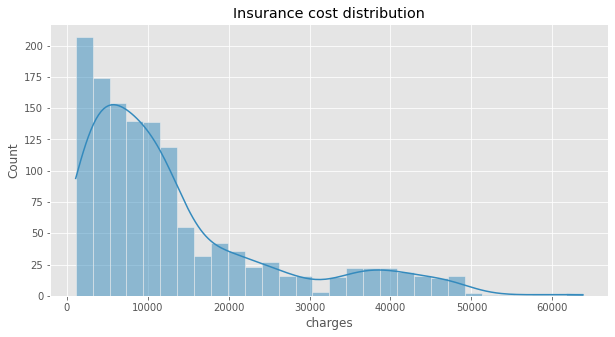

In [ ]:
# Exploratory data analysis
# plot insurance cost distribution

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10,5)
sns.histplot(data=df , x='charges' , bins=30 , kde=True)
plt.title('Insurance cost distribution')

[]

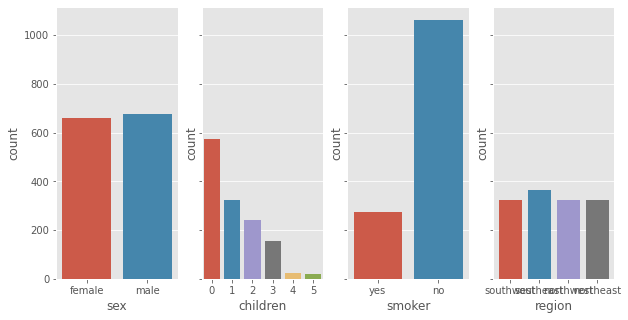

In [ ]:
# plot all variables needed
fig , axs = plt.subplots(nrows=1 , ncols=4 , figsize=(10,5) , sharey=True)
axs = axs.ravel()

for index , col in enumerate(['sex' , 'children' ,'smoker', 'region']) : 
    sns.countplot(data=df , x=col , ax=axs[index])
plt.plot()

In [ ]:
def insurance_cost_by_cat(col):
    fig , axs = plt.subplots(nrows=1 , ncols=2 , figsize=(10,5) , sharex=True )
    axs = axs.ravel()

    sns.histplot(data=df , x='charges' , kde=True , hue=col, ax=axs[0])
    sns.boxenplot(data=df , x='charges', y=col ,orient='h', ax=axs[1])

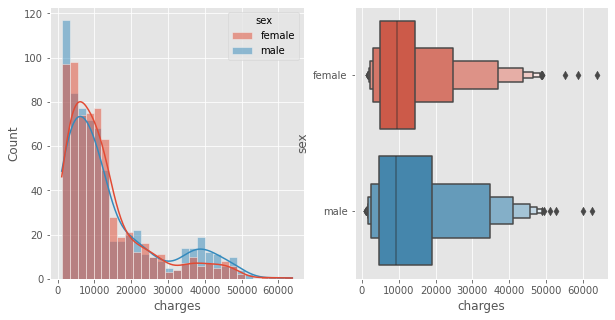

In [ ]:
insurance_cost_by_cat('sex') # plot cost by sex

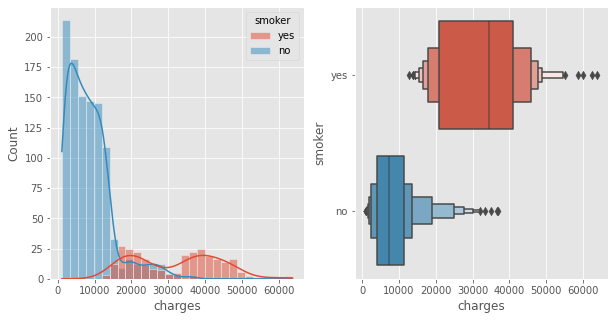

In [ ]:
insurance_cost_by_cat('smoker')

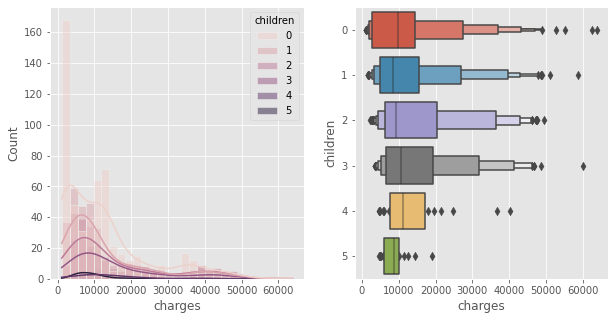

In [ ]:
insurance_cost_by_cat('children')

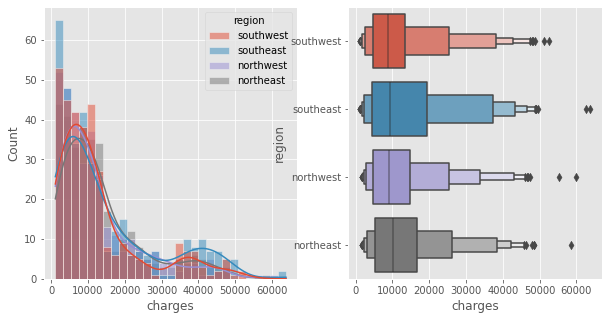

In [ ]:
insurance_cost_by_cat('region')

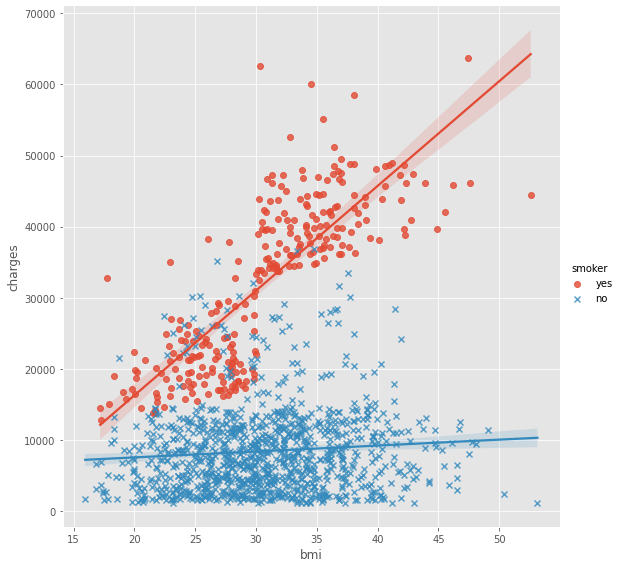

In [ ]:
#regression fit
# cost and BMI linear regression 
sns.lmplot(data=df , x='bmi', y='charges'  , hue='smoker' , height=8 , markers=['o','x'])

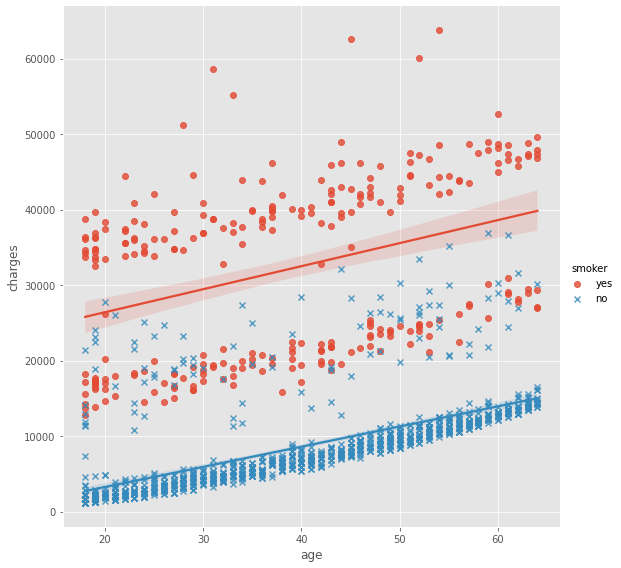

In [ ]:
sns.lmplot(data=df , x='age' , y='charges'  , hue='smoker' , height=8 , markers=['o','x'])

In [ ]:
# data engineering
# Dummy Encoding , Text to numeric before fitting the models


df_dummies = df.copy()

for i in df_dummies.columns : 
    if df_dummies[i].dtype == 'object' : 
        dummies = pd.get_dummies(df_dummies[i] , prefix=f'{i}_')
        df_dummies = pd.concat([df_dummies , dummies] , axis=1)
        df_dummies = df_dummies.drop(i , axis=1)

In [ ]:
df_dummies.head()

,age,bmi,children,charges,sex__female,sex__male,smoker__no,smoker__yes,region__northeast,region__northwest,region__southeast,region__southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


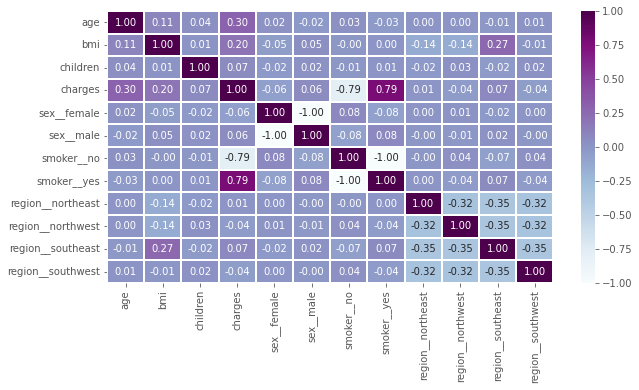

In [ ]:
# correlation of each feature
sns.heatmap(df_dummies.corr() ,annot=True , fmt='.2f' , cmap='BuPu', linewidths=1)

In [ ]:
# Data processing , removing unwanted feature columns, assign charges as target 
features = df_dummies.drop('charges' , axis=1)
target = df_dummies[['charges']]

In [ ]:
# split the data into train test
x_train , x_test  , y_train , y_test = train_test_split( features , target , test_size=0.20 , shuffle=True)

In [ ]:
print('Train size :' , x_train.shape)
print('Test size :' , x_test.shape) 

Train size : (1069, 11)
Test size : (268, 11)


In [ ]:
#  regression model
lis_result = []

def model_prediction(model) : 
    
    fig , axs = plt.subplots(nrows=1 , ncols=2 , figsize=(10,5) , sharex=True ,  sharey=True )
    axs = axs.ravel()
    
    scores = []
    
    for index , degree in enumerate([1,2]) : 
        
        pipeline = Pipeline([
            ('degree' , PolynomialFeatures(degree=degree)) , 
            ('scaled' , StandardScaler()) ,
            ('model' , model)
        ])

        pipeline.fit(x_train , y_train)
        prediction = pipeline.predict(x_test)
        
        r2 = r2_score(prediction , y_test).round(4)
        mae = mean_absolute_error(prediction , y_test).round(1)
        rmse = np.sqrt(mean_squared_error(prediction , y_test)).round(1)
        model_name = str(model).split('(')[0]
        
        scores.append([r2 , mae , rmse])
        lis_result.append([model_name , degree , r2 , mae , rmse])

        
        axs[index].scatter(prediction , y_test , color='b' , alpha=0.4)
        axs[index].plot(np.arange(max(y_test.values)) , np.arange(max(y_test.values)) , '-' , color='r' )
        axs[index].set_xlabel('Prediction')
        axs[index].set_ylabel('Real')
        axs[index].set_title(f'{model_name} with {degree} Degree')
        axs[index].legend([f'R2 : {r2} \nMAE : {mae} \nRMSE : {rmse}'] , loc='upper left')

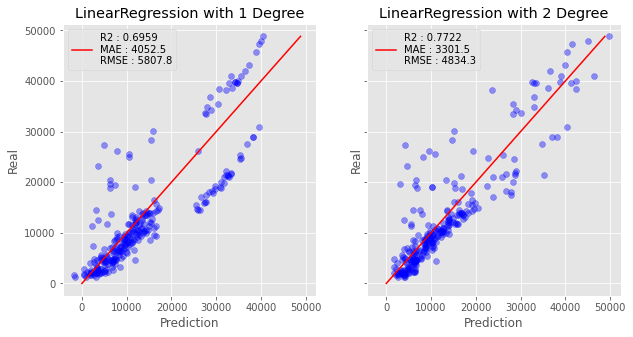

In [ ]:
model_prediction(LinearRegression()) # linear

[18:40:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:40:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


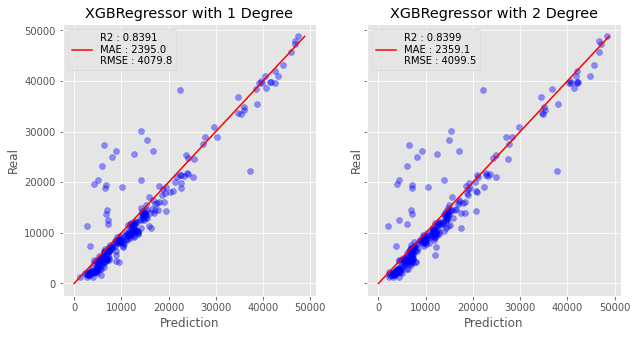

In [ ]:
model_prediction(XGBRegressor()) # XGB

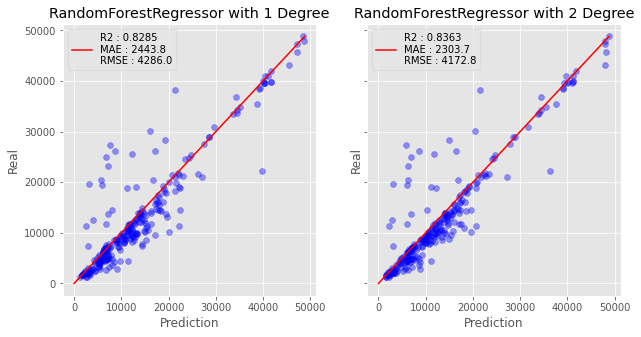

In [ ]:
model_prediction(RandomForestRegressor()) # random forrest , Higher R2 better fit 

In [ ]:
# summary
df_result = pd.DataFrame(lis_result , columns=['Model' , 'Degree' , 'R2' , 'MAE' , 'RMSE']).sort_values(['MAE' , 'RMSE'] , ignore_index=True)
df_result

,Model,Degree,R2,MAE,RMSE
0,RandomForestRegressor,2,0.8363,2303.7,4172.8
1,XGBRegressor,2,0.8399,2359.1,4099.5
2,XGBRegressor,1,0.8391,2395.0,4079.8
3,RandomForestRegressor,1,0.8285,2443.8,4286.0
4,LinearRegression,2,0.7722,3301.5,4834.3
5,LinearRegression,1,0.6959,4052.5,5807.8


In [ ]:
# Random forrest 2nd degree model is beast at predicting the cost using this dataset 